In [1]:
#TF_K_Conv2D_v1
#runs with functions_v_1_3 and 4

In [2]:
import tensorflow as tf

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
#Select on which GPU you want to run
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Or 2, 3, etc. other than 0

In [4]:
#set parameters
save_folder = "TF_K_1"         #Name of the Folder in which all results/plots are saved

train_file_by_file = True              #True if you want to import the trainingsdata file by file
train_on_folder = False                #True if you want to train on all data files within this folder, False if you want to train just with one file
train_data_path = "/eos/home-f/frehm/TF2/Data/EleEscan_1_1/EleEscan_1_1.h5" #path to one training file
train_folder_path = "/eos/home-f/frehm/TF2/Data//"               #directory with more training files inside
train_file_by_file_path = "/data/frehm/File_by_file/"            #data directory

lrate_g = 0.001     #learnrate generator
lrate_d = 0.0003    #learnrate discriminator should be roughly the same ratio g to d parameters
nb_epochs = 40      #number of epochs
percent = 100                       #take just 10 percent of all data for training and testing
latent_size = 200                   #must be 200
batch_size =  128                   #128     #batch_size
keras_dformat = 'channels_first'    #last for CPU, first for GPU
from Models_TF_K_v1 import *
from Functions_v1_4 import *


In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
import argparse
import os
from six.moves import range
import sys
import h5py 
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [6]:
#create output folders for saving files and weights
create_folder(save_folder+'/')
create_folder(save_folder+'/Weights/')
create_folder(save_folder+'/Weights/disc')
create_folder(save_folder+'/Weights/gen')
create_folder(save_folder+'/Pickle/')
create_folder(save_folder+'/Save_Images/')
print('*************************************************************************************')

#import training data
if train_file_by_file == False:
    X,y = import_data(train_on_folder, train_data_path, train_folder_path)
    print('*************************************************************************************') 

    #do data preperation    
    X_train, X_test, y_train, y_test, ecal_train, ecal_test, nb_train, nb_test = data_preperation(X, y, keras_dformat, batch_size, percent)
    y_train = np.expand_dims(y_train, axis=-1)  #macht jeden Eintrag in der Liste zu einer Unterliste [1,2,3]->[[1],[2],[3]]
    y_test  = np.expand_dims(y_test,  axis=-1)
    X_train = tf.constant(X_train)
    X_test  = tf.constant(X_test)
    y_train = tf.constant(y_train)
    y_test  = tf.constant(y_test)
    ecal_train = tf.constant(ecal_train)
    ecal_test  = tf.constant(ecal_test)
    print("X_train_shape: ", X_train.shape)
    print("X_test_shape: ", X_test.shape)
    print("ecal_train_shape: ", ecal_train.shape)
    print("ecal_test_shape: ", ecal_test.shape)
    print('*************************************************************************************')
else:
    files = create_files_list(train_file_by_file_path)
    X_test = []
    y_test = []
    ecal_test = []

Directory  TF_K_1/  already exists
Directory  TF_K_1/Weights/  already exists
Directory  TF_K_1/Weights/disc  already exists
Directory  TF_K_1/Weights/gen  already exists
Directory  TF_K_1/Pickle/  already exists
Directory  TF_K_1/Save_Images/  already exists
*************************************************************************************


In [7]:


generator().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 125)          25125       input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 5, 5, 5)      0           dense[0][0]                      
__________________________________________________________________________________________________
permute (Permute)               (None, 5, 5, 5)      0           reshape[0][0]                    
______________________________________________________________________________________________

In [8]:
discriminator().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 25, 25, 2 0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 25, 25, 25)   0           input_2[0][0]                    
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 25, 25, 25)   0           reshape_2[0][0]                  
__________________________________________________________________________________________________
permute_5 (Permute)             (None, 25, 25, 25)   0           reshape_2[0][0]                  
____________________________________________________________________________________________

In [9]:
discriminator = discriminator(keras_dformat = "channels_first")
generator = generator(latent_size = 200)

#print(discriminator.trainable_variables)
#print(generator.trainable_variables)

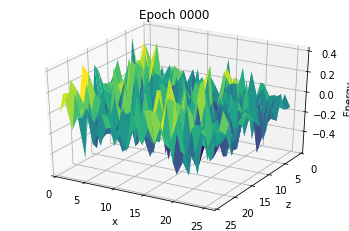

In [10]:
#define plots during training after each epoch
#%matplotlib notebook            #this is for 3D projection
epoch=0

#function for plotting a training images
if train_file_by_file == False:
    plot_images(X, epoch, save_folder, save=False, number=1)

def plot_gen_image_tf(latent_size):   #generate a image 
    tf.random.set_seed(1)     
    noise, gen_aux, generator_input, gen_ecal = func_for_gen_tf(1,latent_size=latent_size)
    tf.random.set_seed(None)
    generated_images = generator(generator_input)
    generated_images = np.squeeze(generated_images, axis=(1,))
    Xgen = generated_images
    plot_images(Xgen, epoch, save_folder, save=True, number=1)
    return

plot_gen_image_tf(latent_size)

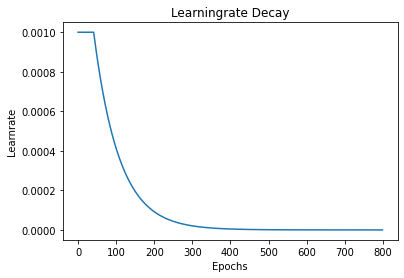

lr last value:  0.0
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0009851119396030628, 0.0009704455335485082, 0.0009559974818331, 0.0009417645335842487, 0.0009277434863285529, 0.0009139311852712283, 0.0009003245225862656, 0.0008869204367171575, 0.0008737159116880345, 0.0008607079764250578, 0.0008478937040879159, 0.000835270211411272, 0.0008228346580560185, 0.0008105842459701871, 0.000798516218759377, 0.0007866278610665535, 0.000774916497961081, 0.0007633794943368531, 0.0007520142543193827, 0.0007408182206817179, 0.0007297888742690569, 0.0007189237334319262, 0.0007082203534678, 0.000697676326071031, 0.0006872892787909723, 0.0006770568744981646, 0.0006669768108584744, 0.0006570468198150568, 0.0006472646670780347, 0.0006376281516217733, 0.000

In [11]:
#learningrate decay
from math import *
def l_dec(initial_lrate, epoch):
    epoch = epoch - 1 #because training starts at epoch 1
    if epoch < 40:
        k = 0.0
    else:
        k = 0.015
        epoch = epoch - 40
    lrate = initial_lrate * exp(-k*epoch)
    return lrate

ep_list=[]
lr_list=[]
for i in range(0,nb_epochs*20):
    ep_list.append(i)
    lr_list.append(l_dec(lrate_g, i))

plt.plot(ep_list,lr_list)
plt.title("Learningrate Decay")
plt.xlabel("Epochs")
plt.ylabel("Learnrate")
plt.show()
print("lr last value: ", round(lr_list[-1],5))
print(lr_list)

In [12]:
#load weights
load_epoch = 16
#generator.load_weights("/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/Conv2D/c2d_5_twisting 3 paths/v5_4/v5_4_5/TF_K_1//Weights/gen/params_generator_epoch_"+ str(load_epoch) + ".hdf5")
#discriminator.load_weights("/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/Conv2D/c2d_5_twisting 3 paths/v5_4/v5_4_5/TF_K_1//Weights/disc/params_discriminator_epoch_"+ str(load_epoch) + ".hdf5")


Epoch 1 of 40
File:  1 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 99s 1s/step
File:  2 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 118s 2s/step
File:  3 / 20
Time for Import: 00:00:10
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 117s 2s/step
File:  4 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 119s 2s/step
File:  5 / 20
Time for Import: 00:00:10
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 124s 2s/step
File:  6 / 20
Time for Import: 00:00:10
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 123s 2s/step
File:  7 / 20
Time for Import: 00

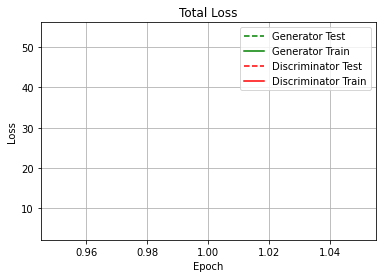

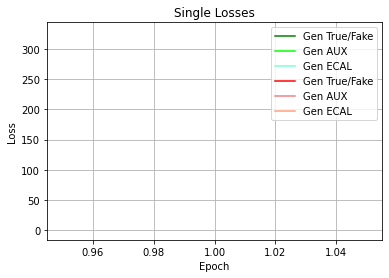

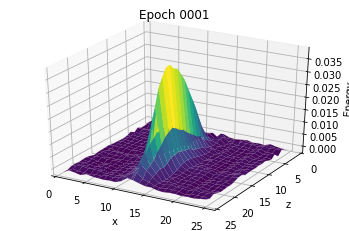

Epoch 2 of 40
File:  1 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 101s 1s/step
File:  2 / 20
Time for Import: 00:00:08
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 110s 2s/step
File:  3 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 100s 1s/step
File:  4 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 101s 1s/step
File:  5 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 99s 1s/step
File:  6 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 103s 1s/step
File:  7 / 20
Time for Import: 00

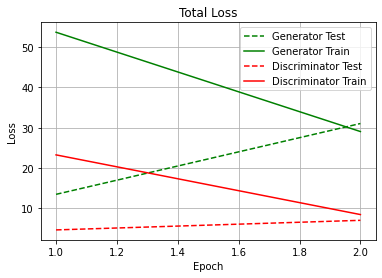

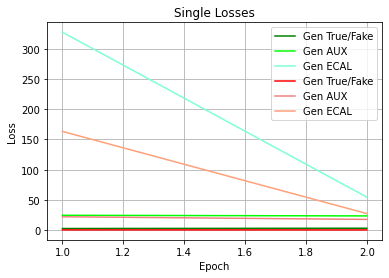

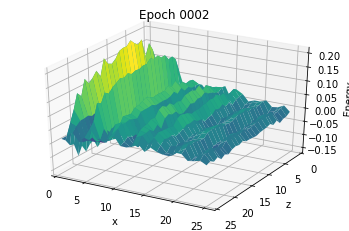

Epoch 3 of 40
File:  1 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 101s 1s/step
File:  2 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.001
Learnrate Discriminator:  0.0003
70/70 [==============================] - 100s 1s/step
File:  3 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0009851119396030628
Learnrate Discriminator:  0.0002955335818809188
70/70 [==============================] - 101s 1s/step
File:  4 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0009704455335485082
Learnrate Discriminator:  0.00029113366006455245
70/70 [==============================] - 102s 1s/step
File:  5 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0009559974818331
Learnrate Discriminator:  0.00028679924454992996
70/70 [==============================] - 101s 1s/step
File:  6 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0009417645335842487
Learnrate D

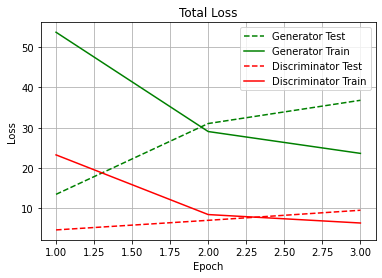

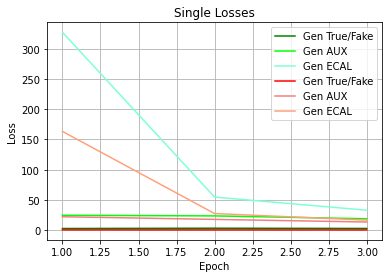

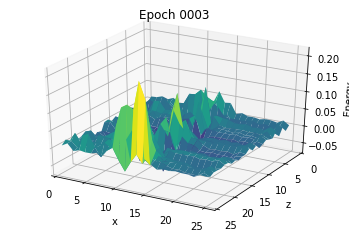

Epoch 4 of 40
File:  1 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0007520142543193827
Learnrate Discriminator:  0.00022560427629581478
70/70 [==============================] - 102s 1s/step
File:  2 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0007408182206817179
Learnrate Discriminator:  0.00022224546620451535
70/70 [==============================] - 101s 1s/step
File:  3 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0007297888742690569
Learnrate Discriminator:  0.00021893666228071704
70/70 [==============================] - 103s 1s/step
File:  4 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0007189237334319262
Learnrate Discriminator:  0.00021567712002957783
70/70 [==============================] - 102s 1s/step
File:  5 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0007082203534678
Learnrate Discriminator:  0.00021246610604033997
70/70 [==============================] - 102s 1s/step
File:  6 / 20
Time for Import: 00:

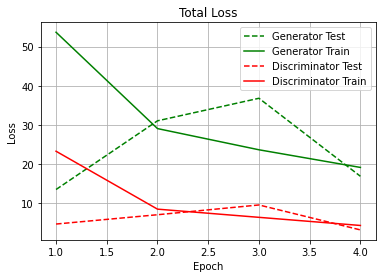

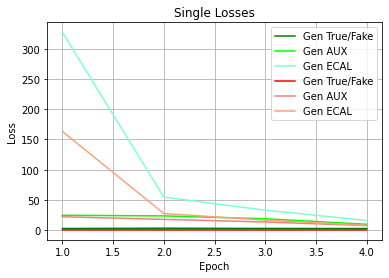

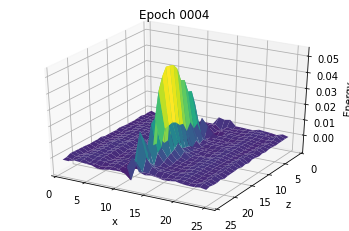

Epoch 5 of 40
File:  1 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0005571058618121739
Learnrate Discriminator:  0.00016713175854365215
70/70 [==============================] - 101s 1s/step
File:  2 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0005488116360940264
Learnrate Discriminator:  0.0001646434908282079
70/70 [==============================] - 103s 1s/step
File:  3 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0005406408953093166
Learnrate Discriminator:  0.00016219226859279497
70/70 [==============================] - 101s 1s/step
File:  4 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.0005325918010068972
Learnrate Discriminator:  0.00015977754030206914
70/70 [==============================] - 102s 1s/step
File:  5 / 20
Time for Import: 00:00:09
Learnrate Generator:      0.000524662542106593
Learnrate Discriminator:  0.00015739876263197786
70/70 [==============================] - 103s 1s/step
File:  6 / 20
Time for Import: 00

In [ ]:
#training
verbose = 'true'

train_history = defaultdict(list)   #create a dict with an empty list 
test_history = defaultdict(list)

start_epoch = 1             #i want to start traing at epoch 1
for epoch in range(start_epoch, nb_epochs + 1):
    print('Epoch {} of {}'.format(epoch, nb_epochs))
    start_epoch = time.time()
    lr_d = l_dec(lrate_d, epoch)
    lr_g = l_dec(lrate_g, epoch)
    optimizer_d = tf.optimizers.Adam(lr_d)
    optimizer_g = tf.optimizers.Adam(lr_g)
    epoch_gen_loss = []
    epoch_disc_loss = []
    
    if 'X_test' in locals() and train_file_by_file == True:
        del X_test
        del y_test
        del ecal_test
    if train_file_by_file == False:
        files = [1]
    
    #Iterate over the number of trainingsfiles
    for file_number in range(len(files)):
        
        #import data file by file method
        if train_file_by_file == True:
            start_import = time.time()
            print("File: ", file_number+1, "/", len(files))
            X, y = train_file_by_file_import(train_file_by_file_path, files, file_number)
            X_train, X_test_file, y_train, y_test_file, ecal_train, ecal_test_file, nb_train, nb_test = data_preperation(X, y, keras_dformat, batch_size, percent)
            y_train = np.expand_dims(y_train, axis=-1)  #macht jeden Eintrag in der Liste zu einer Unterliste [1,2,3]->[[1],[2],[3]]
            y_test_file = np.expand_dims(y_test_file, axis=-1)
            if 'X_test' in locals():
                X_test = np.concatenate((X_test, X_test_file))
                y_test = np.concatenate((y_test, y_test_file))
                ecal_test = np.concatenate((ecal_test, ecal_test_file))
            else: 
                X_test = X_test_file
                y_test = y_test_file
                ecal_test = ecal_test_file
            nb_test=len(y_test)
            end_import = time.time()
            e2 = int(end_import-start_import)
            print('Time for Import: {:02d}:{:02d}:{:02d}'.format(e2 // 3600, (e2 % 3600 // 60), e2 % 60))
            
            lr_d = l_dec(lrate_d, epoch*20+file_number-20)
            lr_g = l_dec(lrate_g, epoch*20+file_number-20)
            optimizer_d = tf.optimizers.Adam(lr_d)
            optimizer_g = tf.optimizers.Adam(lr_g)
        print("Learnrate Generator:     ", lr_g)
        print("Learnrate Discriminator: ", lr_d)
        nb_batches = int(X_train.shape[0] / batch_size)
        if verbose:
            progress_bar = tf.keras.utils.Progbar(target=nb_batches)
        ################################################################################
        
        #training; loop over epochs
        for batch in range(nb_batches):
            if verbose:
                progress_bar.update(batch+1)
            else:
                if epoch % 100 == 0:
                    print('processed {}/{} batches'.format(batch + 1, nb_batches))

            #create batches
            image_batch  = X_train[(batch*batch_size) : ((batch+1)*batch_size)]
            energy_batch = y_train[(batch*batch_size) : ((batch+1)*batch_size)]
            ecal_batch   = ecal_train[(batch*batch_size) : ((batch+1)*batch_size)]

            #discriminator true training
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(discriminator.trainable_variables)
                d_loss_true = disc_loss(generator, discriminator, image_batch, energy_batch, ecal_batch, batch_size, label ="ones")
                d_grads = tape.gradient( d_loss_true[0] , discriminator.trainable_variables )
            optimizer_d.apply_gradients( zip( d_grads , discriminator.trainable_variables) )
            
            #discriminator fake training
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(discriminator.trainable_variables)
                noise, gen_aux, generator_input, gen_ecal = func_for_gen_tf(nb_test=batch_size) 
                generated_images = generator(generator_input)
                d_loss_fake = disc_loss(generator, discriminator, generated_images, gen_aux, gen_ecal, batch_size, label = "zeros")
                d_grads = tape.gradient( d_loss_fake[0] , discriminator.trainable_variables )
            optimizer_d.apply_gradients( zip( d_grads , discriminator.trainable_variables) )
            d_loss = []
            d_loss.append( (d_loss_true[0] + d_loss_fake[0])/2)
            d_loss.append( (d_loss_true[1] + d_loss_fake[1])/2)
            d_loss.append( (d_loss_true[2] + d_loss_fake[2])/2)
            d_loss.append( (d_loss_true[3] + d_loss_fake[3])/2)
            epoch_disc_loss.append([d_loss[0].numpy(), d_loss[1].numpy(), d_loss[2].numpy(), d_loss[3].numpy()])  
            
            #generator training
            gen_losses = []
            for i in range(1):
                with tf.GradientTape(watch_accessed_variables=False) as tape:
                    tape.watch(generator.trainable_variables)
                    g_loss = gen_loss(generator, discriminator, batch_size)
                    g_grads = tape.gradient( g_loss[0] , generator.trainable_variables )
                optimizer_g.apply_gradients( zip( g_grads , generator.trainable_variables ) )
                gen_losses.append([g_loss[0].numpy(), g_loss[1].numpy(), g_loss[2].numpy(), g_loss[3].numpy()])
            epoch_gen_loss.append(np.mean(gen_losses, axis = 0))
    ################################################################################
    #testing
    nb_batches = int(X_test.shape[0] / batch_size)
    if nb_batches == 0:  #I need this or I get an error if I reduce the data with percentage
        nb_batches = 1
    disc_test_loss_list = []
    gen_test_loss_list = []
    for batch in range(nb_batches):
        #create batches
        image_batch  = X_test[(batch*batch_size) : ((batch+1)*batch_size)]
        energy_batch = y_test[(batch*batch_size) : ((batch+1)*batch_size)]
        ecal_batch   = ecal_test[(batch*batch_size) : ((batch+1)*batch_size)]

        d_test_loss_true = disc_loss(generator, discriminator, image_batch, energy_batch, ecal_batch, batch_size, label ="ones")
        noise, gen_aux, generator_input, gen_ecal = func_for_gen_tf(nb_test=batch_size) 
        generated_images = generator(generator_input)
        d_test_loss_fake = disc_loss(generator, discriminator, generated_images, gen_aux, gen_ecal, batch_size, label = "zeros")
        d_test_loss = []
        d_test_loss.append( (d_test_loss_true[0] + d_test_loss_fake[0])/2)
        d_test_loss.append( (d_test_loss_true[1] + d_test_loss_fake[1])/2)
        d_test_loss.append( (d_test_loss_true[2] + d_test_loss_fake[2])/2)
        d_test_loss.append( (d_test_loss_true[3] + d_test_loss_fake[3])/2)
        disc_test_loss_list.append([d_test_loss[0].numpy(), d_test_loss[1].numpy(), d_test_loss[2].numpy(), d_test_loss[3].numpy()])

        gen_test_loss = gen_loss(generator, discriminator, batch_size)
        gen_test_loss_list.append([gen_test_loss[0].numpy(), gen_test_loss[1].numpy(), gen_test_loss[2].numpy(), gen_test_loss[3].numpy()])

    #######################################################################
    #loss dict
    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)   #mean disc loss for all epochs
    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
    discriminator_test_loss = np.mean(np.array(disc_test_loss_list), axis=0)
    generator_test_loss = np.mean(np.array(gen_test_loss_list), axis=0)
    
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)
    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)
    end_d = time.time()
    
    #calculate time for epoch
    end_batch = time.time()
    e = int(end_batch-start_epoch)
    print('Time for Epoch: {:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))
    
    #print loss table and plot generated image; also save them
    loss_table(train_history, test_history, save_folder, epoch, save=True, timeforepoch = e)
    plot_loss(train_history, test_history, save_folder, save=True)
    #plot a generated image
    plot_gen_image_tf(latent_size)
    
    #dump data
    pickle.dump([train_history, test_history], open(save_folder+'/Pickle/3dgan-history.pkl', 'wb'))  #my history
    pickle.dump({'train': train_history, 'test': test_history}, open(save_folder+'/Pickle/3dgan-history_dict.pkl', 'wb')) #for validation script
    if epoch >10: #save model
        generator.save_weights(save_folder+"/Weights/gen/params_generator_epoch_"+str(epoch)+".hdf5",overwrite=True)
        discriminator.save_weights(save_folder+"/Weights/disc/params_discriminator_epoch_"+str(epoch)+".hdf5",overwrite=True)
        #save model as .pb
        generator.save(save_folder + "/Weights/Generator/G"+str(epoch)) 
        discriminator.save(save_folder + "/Weights/Discriminator/D"+str(epoch))
    

In [ ]:
error

## Validation


In [ ]:
generator = tf.saved_model.load(save_folder + "/Generator2")

In [ ]:
#import pickle history
import pickle
pickle_import = pickle.load( open( '/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/run11/run11/Pickle/3dgan-history.pkl', "rb" ) )
#print((pickle_import))
train_history = pickle_import[0]
test_history  = pickle_import[1]

In [ ]:
#load weights
load_epoch = 1
d_weights = pickle.load( open(save_folder + "/Weights/disc/disc_weights_"+ str(load_epoch) + ".p", "rb") )
g_weights = pickle.load( open(save_folder + "/Weights/gen/gen_weights_"+ str(load_epoch) + ".p", "rb") )

In [ ]:
#plot loss graph
plot_loss(train_history, test_history)

In [ ]:
#print table
loss_table(train_history,test_history)

In [ ]:
#plot a trainingsimage

#this is for 3D projection
#%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  #I need this for my plot

#plot some training images
plot_images(X, 0, save_folder, save=False, number=1)

In [ ]:
#plot of generated image
plot_gen_image_tf(latent_size, g_weights)

In [ ]:
error

In [ ]:
#save weights
#pickle.dump( d_weights, open( "d_weights.p", "wb" ) )